## Step 0: Installing prerequisites

In [1]:
!nvidia-smi  # Verify GPU availability

Sun Jul 27 21:31:25 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   40C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# Install required packages
!pip install ultralytics # Install required packages

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 54.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 73.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 56.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

In [ ]:
# Import necessary packages
import albumentations as A
from albumentations.pytorch import ToTensorV2
from collections import Counter
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import random
from sklearn.metrics import average_precision_score
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
import torchvision.models as models
from transformers import ViTConfig, ViTModel
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Step 1: Upload and unzip dataset from device

In [5]:
# Define dataset directory
dataset_dir = "/content/facial-expression-in-classroom-12"

In [6]:
# Check if ZIP file exists and unzip
zip_path = "/content/facial-expression-in-classroom-12.zip"
if not os.path.exists(zip_path):
    raise FileNotFoundError(f"Dataset ZIP file not found at {zip_path}. Please upload it to Colab.")
!unzip -q {zip_path} -d /content

In [7]:
# Verify dataset directory structure
if not os.path.exists(os.path.join(dataset_dir, "train/images")) or \
   not os.path.exists(os.path.join(dataset_dir, "train/labels")) or \
   not os.path.exists(os.path.join(dataset_dir, "data.yaml")):
    raise FileNotFoundError(f"Dataset directory {dataset_dir} is missing required files (train/images, train/labels, data.yaml).")

In [8]:
# Function to count images and labels in a dataset split
def count_images_and_labels(dataset_dir, split):
    images_dir = os.path.join(dataset_dir, f"{split}/images")
    labels_dir = os.path.join(dataset_dir, f"{split}/labels")

    image_count = 0
    label_count = 0

    if os.path.exists(images_dir):
        image_files = [f for f in os.listdir(images_dir) if f.endswith('.jpg')]
        image_count = len(image_files)
    else:
        print(f"Warning: {images_dir} does not exist.")

    if os.path.exists(labels_dir):
        label_files = [f for f in os.listdir(labels_dir) if f.endswith('.txt')]
        label_count = len(label_files)
    else:
        print(f"Warning: {labels_dir} does not exist.")

    return image_count, label_count

# Count images and labels for all splits
splits = ['train']
total_images = 0
total_labels = 0
print("\n=== Dataset Summary ===")
for split in splits:
    images, labels = count_images_and_labels(dataset_dir, split)
    print(f"{split.capitalize()} split: {images} images, {labels} labels")
    total_images += images
    total_labels += labels

print(f"Total: {total_images} images, {total_labels} labels")

# Verify that the number of images matches the number of labels
if total_images != total_labels:
    print(f"Warning: Mismatch between total images ({total_images}) and labels ({total_labels}). Some images may lack corresponding label files or vice versa.")


=== Dataset Summary ===
Train split: 1162 images, 1162 labels
Total: 1162 images, 1162 labels


In [9]:
# Create a custom dataset object to mimic Roboflow's dataset
class Dataset:
    def __init__(self, location):
        self.location = location

dataset = Dataset(dataset_dir)

## Step 2: Define the HybridViT model (FER model)

In [10]:
# Define the HybridViT model (FER model)
class HybridViT(nn.Module):
    def __init__(self, num_classes=7, embed_dim=768):
        super(HybridViT, self).__init__()

        # ResNet-50 Backbone
        resnet = models.resnet50(pretrained=True)
        self.resnet_features = nn.Sequential(*list(resnet.children())[:-2])  # Remove FC and avgpool

        # Adjust channels and upsample to match ViT input size
        self.conv = nn.Conv2d(2048, 3, kernel_size=1)  # Match ViT's expected 3 channels
        self.upsample = nn.Upsample(size=(224, 224), mode='bilinear', align_corners=False)

        # ViT Configuration
        vit_config = ViTConfig(
            hidden_size=embed_dim,
            num_hidden_layers=12,
            num_attention_heads=12,
            intermediate_size=3072,
            image_size=224,
            patch_size=16,
            num_channels=3  # Standard RGB input
        )
        self.vit = ViTModel(vit_config)

        # Classifier
        self.classifier = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        # Extract features with ResNet-50
        features = self.resnet_features(x)  # Shape: (batch, 2048, 7, 7)
        features = self.conv(features)  # Shape: (batch, 3, 7, 7)
        features = self.upsample(features)  # Shape: (batch, 3, 224, 224)

        # Pass through ViT
        outputs = self.vit(pixel_values=features)
        pooled_output = outputs.last_hidden_state[:, 0]  # Use [CLS] token

        # Classification
        logits = self.classifier(pooled_output)
        return logits

## Step 3: Load models

In [ ]:
# Load YOLOv11 face detection model
yolo_model = YOLO("/content/drive/MyDrive/[Sem. 7 & 8] Seminar & Skripsi/Program/Model/YOLOv11s_Face_Detection.pt")

# Load Hybrid ViT FER model
fer_model = HybridViT(num_classes=7)
fer_model.load_state_dict(torch.load("/content/drive/MyDrive/[Sem. 7 & 8] Seminar & Skripsi/Program/Model/Hybrid_ViT_FER.pth"))

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 58.9MB/s]


<All keys matched successfully>

In [12]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
fer_model.to(device)

HybridViT(
  (resnet_features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): C

## Step 4: Define preprocessing for FER model

In [13]:
# Define preprocessing for FER model
preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [14]:
# Class names (aligned with dataset)
class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
dataset_to_fer_label_map = {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}

## Step 5: Create a dataset for evaluation

In [15]:
# Create a dataset for fine-tuning and evaluation
class ClassroomDataset(Dataset):
    def __init__(self, image_dir, label_dir, num_images=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
        if num_images:
            self.image_files = random.sample(self.image_files, min(num_images, len(self.image_files)))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_name = self.image_files[idx]
        image_path = os.path.join(self.image_dir, image_name)
        label_path = os.path.join(self.label_dir, image_name.replace('.jpg', '.txt'))

        image = cv2.imread(image_path)
        if image is None:
            raise ValueError(f"Could not load image: {image_path}")
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        true_labels = []
        bboxes = []
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) != 5:
                        print(f"Warning: Malformed label in {label_path}: {line.strip()}")
                        continue
                    label, x_center, y_center, width, height = map(float, parts)
                    label = int(label)
                    true_labels.append(dataset_to_fer_label_map[label])
                    h, w = image.shape[:2]
                    x_center, y_center, width, height = x_center * w, y_center * h, width * w, height * h
                    bboxes.append([x_center, y_center, width, height])

        return image_rgb, true_labels, bboxes, image_path

In [16]:
# Custom collate function
def custom_collate_fn(batch):
    images, true_labels, bboxes, paths = zip(*batch)
    return images, true_labels, bboxes, paths

## Step 6: Fine-tune the FER model on the classroom dataset

In [17]:
# Fine-tune the FER model on the classroom dataset
def fine_tune_fer_model(dataset, fer_model, device, num_epochs=50, batch_size=32):
    # Data Augmentation for Training (more aggressive for Fear, Disgust, Sad)
    train_transform = A.Compose([
        A.Rotate(limit=15, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.4, contrast_limit=0.4, p=0.5),  # More extreme lighting
        A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=30, p=0.3),
        A.RandomCrop(height=224, width=224, p=0.3),  # Assuming input size is 224x224
        A.GaussNoise(var=(10.0, 50.0), p=0.3),  # Updated 'var_limit' to 'var'
        A.Affine(translate_percent=0.1, scale=(0.9, 1.1), rotate=0, p=0.3),  # Replaced ShiftScaleRotate with Affine
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ])

    # Validation transform (no augmentation, just normalization)
    val_transform = A.Compose([
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ])

    # Prepare dataset for fine-tuning
    full_dataset = ClassroomDataset(
        image_dir=os.path.join(dataset.location, "train/images"),
        label_dir=os.path.join(dataset.location, "train/labels"),
        num_images=1162
    )

    # Split into train and validation (80/20 split)
    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

    # Function to count images and labels in a dataset split
    def count_images_and_labels(dataset_subset):
        image_count = len(dataset_subset)
        label_count = 0
        for idx in range(len(dataset_subset)):
            _, true_labels, _, _ = dataset_subset[idx]
            label_count += len(true_labels)  # Count number of annotations (faces) in label file
        return image_count, label_count

    # Count images and labels for train and validation splits
    print("\n=== Dataset Split Summary ===")
    train_images, train_labels = count_images_and_labels(train_dataset)
    val_images, val_labels = count_images_and_labels(val_dataset)
    print(f"Training split: {train_images} images, {train_labels} labels")
    print(f"Validation split: {val_images} images, {val_labels} labels")
    print(f"Total: {train_images + val_images} images, {train_labels + val_labels} labels")

    # Verify that labels exist for images
    if train_labels == 0 or val_labels == 0:
        print(f"Warning: No labels found in {'training' if train_labels == 0 else 'validation'} split. Check label files.")

    # Apply transforms
    train_dataset.dataset.transform = train_transform
    val_dataset.dataset.transform = val_transform

    # DataLoaders with reduced num_workers
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, collate_fn=custom_collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, collate_fn=custom_collate_fn)

    # Compute class weights to handle imbalance
    all_labels = []
    for _, true_labels, _, _ in train_dataset:
        all_labels.extend(true_labels)
    label_counts = Counter(all_labels)
    total_samples = len(all_labels)
    class_weights = torch.tensor([min(total_samples / (len(class_names) * label_counts[i]), 3.0) if label_counts[i] > 0 else 0.0 for i in range(len(class_names))], dtype=torch.float).to(device)  # Fixed torchfloat to torch.float

    # Define optimizer with higher weight decay
    optimizer = optim.Adam(fer_model.parameters(), lr=5e-5, weight_decay=5e-5)

    # Add learning rate scheduler (cosine annealing)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    # Loss function
    criterion = nn.CrossEntropyLoss(weight=class_weights)

    # Function to compute mAP
    def compute_map(predictions, true_labels, num_classes=7):
        ap_scores = []
        for cls in range(num_classes):
            true_binary = (true_labels == cls).float().cpu().numpy()
            pred_scores = predictions[:, cls].cpu().numpy()
            if true_binary.sum() > 0:
                ap = average_precision_score(true_binary, pred_scores)
                ap_scores.append(ap)
            else:
                ap_scores.append(0.0)
        return np.mean(ap_scores), ap_scores

    # Fine-tuning loop with early stopping
    best_val_map = 0.0
    epochs_no_improve = 0
    patience = 5  # Stop if no improvement for 5 epochs
    fer_model.train()

    for epoch in range(num_epochs):
        total_loss = 0
        for batch_idx, (batch_images, batch_true_labels, batch_bboxes, batch_paths) in enumerate(train_loader):
            batch_images = batch_images[0]
            batch_true_labels = batch_true_labels[0]
            batch_bboxes = batch_bboxes[0]

            faces_batch = []
            labels_batch = []
            for bbox, label in zip(batch_bboxes, batch_true_labels):
                x_center, y_center, width, height = bbox
                padding = 0.2
                x1 = int(max(0, x_center - width / 2 * (1 + padding)))
                y1 = int(max(0, y_center - height / 2 * (1 + padding)))
                x2 = int(min(batch_images.shape[1], x_center + width / 2 * (1 + padding)))
                y2 = int(min(batch_images.shape[0], y_center + height / 2 * (1 + padding)))
                if x2 - x1 < 64:
                    center_x = (x1 + x2) / 2
                    x1 = int(max(0, center_x - 32))
                    x2 = int(min(batch_images.shape[1], center_x + 32))
                if y2 - y1 < 64:
                    center_y = (y1 + y2) / 2
                    y1 = int(max(0, center_y - 32))
                    y2 = int(min(batch_images.shape[0], center_y + 32))

                face = batch_images[y1:y2, x1:x2]
                if face.size == 0:
                    continue
                face_rgb = cv2.cvtColor(face, cv2.COLOR_RGB2BGR)
                face_tensor = preprocess(face_rgb)
                faces_batch.append(face_tensor)
                labels_batch.append(label)

            if not faces_batch:
                continue

            faces_tensor = torch.stack(faces_batch).to(device)
            labels_tensor = torch.tensor(labels_batch, dtype=torch.long).to(device)

            optimizer.zero_grad()
            logits = fer_model(faces_tensor)
            loss = criterion(logits, labels_tensor)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(fer_model.parameters(), max_norm=1.0)
            optimizer.step()

            total_loss += loss.item()

        # Step the learning rate scheduler
        scheduler.step()

        avg_train_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{num_epochs}, Average Train Loss: {avg_train_loss:.4f}")

        # Validation phase
        fer_model.eval()
        val_predictions = []
        val_true_labels = []
        val_loss = 0.0
        with torch.no_grad():
            for batch_images, batch_true_labels, batch_bboxes, batch_paths in val_loader:
                batch_images = batch_images[0]
                batch_true_labels = batch_true_labels[0]
                batch_bboxes = batch_bboxes[0]

                faces_batch = []
                labels_batch = []
                for bbox, label in zip(batch_bboxes, batch_true_labels):
                    x_center, y_center, width, height = bbox
                    padding = 0.2
                    x1 = int(max(0, x_center - width / 2 * (1 + padding)))
                    y1 = int(max(0, y_center - height / 2 * (1 + padding)))
                    x2 = int(min(batch_images.shape[1], x_center + width / 2 * (1 + padding)))
                    y2 = int(min(batch_images.shape[0], y_center + height / 2 * (1 + padding)))
                    if x2 - x1 < 64:
                        center_x = (x1 + x2) / 2
                        x1 = int(max(0, center_x - 32))
                        x2 = int(min(batch_images.shape[1], center_x + 32))
                    if y2 - y1 < 64:
                        center_y = (y1 + y2) / 2
                        y1 = int(max(0, center_y - 32))
                        y2 = int(min(batch_images.shape[0], center_y + 32))

                    face = batch_images[y1:y2, x1:x2]
                    if face.size == 0:
                        continue
                    face_rgb = cv2.cvtColor(face, cv2.COLOR_RGB2BGR)
                    face_tensor = preprocess(face_rgb)
                    faces_batch.append(face_tensor)
                    labels_batch.append(label)

                if not faces_batch:
                    continue

                faces_tensor = torch.stack(faces_batch).to(device)
                labels_tensor = torch.tensor(labels_batch, dtype=torch.long).to(device)

                logits = fer_model(faces_tensor)
                loss = criterion(logits, labels_tensor)
                val_loss += loss.item()

                probs = torch.softmax(logits, dim=1)
                val_predictions.append(probs.cpu())
                val_true_labels.append(labels_tensor.cpu())

        avg_val_loss = val_loss / len(val_loader)
        val_predictions = torch.cat(val_predictions)
        val_true_labels = torch.cat(val_true_labels)

        # Compute validation mAP
        val_map, val_ap_scores = compute_map(val_predictions, val_true_labels)
        print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {avg_val_loss:.4f}, Validation mAP: {val_map:.4f}")
        for cls, ap in enumerate(val_ap_scores):
            print(f"AP for {class_names[cls]}: {ap:.4f}")

        # Save the best model based on validation mAP
        if val_map > best_val_map:
            best_val_map = val_map
            torch.save(fer_model.state_dict(), "/content/drive/MyDrive/[Sem. 7 & 8] Seminar & Skripsi/Program/Model/HybridViT_ResNet-50_FER.pth")
            print(f"Saved best model with Validation mAP: {best_val_map:.4f}")
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            print(f"No improvement in validation mAP for {epochs_no_improve} epoch(s)")

        # Early stopping
        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch+1} due to no improvement in validation mAP")
            break

    fer_model.eval()
    print("Fine-tuning completed!")

## Step 7: Face detection and FER pipeline

In [18]:
# Face detection and FER pipeline (updated face cropping)
def detect_and_classify(image_rgb, yolo_model, fer_model, device, conf_threshold=0.25, yolo_input_size=1280):
    if isinstance(image_rgb, torch.Tensor):
        image_rgb = image_rgb.cpu().numpy()
        if image_rgb.shape[0] in [1, 3]:
            image_rgb = image_rgb.transpose(1, 2, 0)
        if image_rgb.dtype != np.uint8:
            image_rgb = (image_rgb * 255).astype(np.uint8)

    if not isinstance(image_rgb, np.ndarray):
        raise ValueError(f"image_rgb is not a NumPy array. Type: {type(image_rgb)}")
    if image_rgb.size == 0:
        raise ValueError("image_rgb is empty.")
    print(f"image_rgb shape: {image_rgb.shape}, dtype: {image_rgb.dtype}")

    h, w = image_rgb.shape[:2]
    scale = min(yolo_input_size / h, yolo_input_size / w)
    new_h, new_w = int(h * scale), int(w * scale)
    new_h = (new_h // 32) * 32
    new_w = (new_w // 32) * 32
    image_resized = cv2.resize(image_rgb, (new_w, new_h), interpolation=cv2.INTER_LINEAR)

    results = yolo_model.predict(image_resized, conf=conf_threshold, verbose=False, imgsz=yolo_input_size)
    bboxes = []
    for result in results:
        boxes = result.boxes.xywh.cpu().numpy()
        scale_x, scale_y = w / new_w, h / new_h
        boxes[:, 0] *= scale_x
        boxes[:, 1] *= scale_y
        boxes[:, 2] *= scale_x
        boxes[:, 3] *= scale_y
        bboxes.extend(boxes)

    print(f"Detected {len(bboxes)} faces in image")

    predictions = []
    confidences = []
    faces_batch = []
    bbox_indices = []

    for idx, bbox in enumerate(bboxes):
        x_center, y_center, width, height = bbox
        # Add 20% padding to the bounding box
        padding = 0.2
        x1 = int(max(0, x_center - width / 2 * (1 + padding)))
        y1 = int(max(0, y_center - height / 2 * (1 + padding)))
        x2 = int(min(w, x_center + width / 2 * (1 + padding)))
        y2 = int(min(h, y_center + height / 2 * (1 + padding)))
        # Ensure minimum size of 64x64
        if x2 - x1 < 64:
            center_x = (x1 + x2) / 2
            x1 = int(max(0, center_x - 32))
            x2 = int(min(w, center_x + 32))
        if y2 - y1 < 64:
            center_y = (y1 + y2) / 2
            y1 = int(max(0, center_y - 32))
            y2 = int(min(h, center_y + 32))

        face = image_rgb[y1:y2, x1:x2]
        if face.size == 0:
            continue

        face_rgb = cv2.cvtColor(face, cv2.COLOR_RGB2BGR)
        face_tensor = preprocess(face_rgb)
        faces_batch.append(face_tensor)
        bbox_indices.append(idx)

    if faces_batch:
        faces_tensor = torch.stack(faces_batch).to(device)
        with torch.no_grad():
            logits = fer_model(faces_tensor)
            probs = torch.softmax(logits, dim=1)
            confidences_batch, predicted_batch = torch.max(probs, 1)
            for idx, pred, conf in zip(bbox_indices, predicted_batch, confidences_batch):
                predictions.append(pred.item())
                confidences.append(conf.item())

    return bboxes, predictions, confidences

## Step 8: Compute mAP and latency

In [19]:
# Compute mAP and latency (added debug output and all requested metrics)
def evaluate_pipeline(dataset, yolo_model, fer_model, device, batch_size=32, num_images=233):
    eval_dataset = ClassroomDataset(
        image_dir=os.path.join(dataset.location, "train/images"),
        label_dir=os.path.join(dataset.location, "train/labels"),
        num_images=num_images
    )
    dataloader = DataLoader(eval_dataset, batch_size=1, shuffle=False, num_workers=0, collate_fn=custom_collate_fn)

    all_true_labels = []
    all_pred_labels = []
    all_pred_probs = []
    total_latency = 0
    num_faces_processed = 0
    num_images_processed = 0  # Counter for images

    fer_model.eval()
    for batch_idx, (batch_images, batch_true_labels, batch_bboxes, batch_paths) in enumerate(dataloader):
        batch_images = batch_images[0]
        batch_true_labels = batch_true_labels[0]
        batch_bboxes = batch_bboxes[0]
        num_images_processed += 1  # Increment image counter

        print(f"Batch {batch_idx}: batch_bboxes type: {type(batch_bboxes)}, len: {len(batch_bboxes)}")
        if batch_bboxes:
            print(f"First bbox: {batch_bboxes[0]}")

        start_time = time.time()
        detected_bboxes, predictions, confidences = detect_and_classify(
            batch_images, yolo_model, fer_model, device, conf_threshold=0.25, yolo_input_size=1280
        )
        latency = time.time() - start_time
        total_latency += latency

        matched_predictions = []
        matched_true_labels = []
        for true_idx, (true_bbox, true_label) in enumerate(zip(batch_bboxes, batch_true_labels)):
            if len(true_bbox) != 4:
                print(f"Warning: Malformed bbox at index {true_idx}: {true_bbox}")
                continue
            if not detected_bboxes:
                continue
            true_center = np.array([true_bbox[0], true_bbox[1]])
            detected_centers = np.array([[bbox[0], bbox[1]] for bbox in detected_bboxes])
            distances = np.linalg.norm(detected_centers - true_center, axis=1)
            closest_idx = np.argmin(distances)
            distance = distances[closest_idx]

            if distance < 100:
                pred_label = predictions[closest_idx]
                matched_predictions.append(pred_label)
                matched_true_labels.append(true_label)
                # Debug: Log mismatched predictions
                if pred_label != true_label:
                    print(f"Mismatch in Batch {batch_idx}, Face {true_idx}: True={class_names[true_label]}, Predicted={class_names[pred_label]}")

                face = batch_images[int(max(0, true_bbox[1] - true_bbox[3]/2)):int(min(batch_images.shape[0], true_bbox[1] + true_bbox[3]/2)),
                                    int(max(0, true_bbox[0] - true_bbox[2]/2)):int(min(batch_images.shape[1], true_bbox[0] + true_bbox[2]/2))]
                if face.size == 0:
                    continue
                face_rgb = cv2.cvtColor(face, cv2.COLOR_RGB2BGR)
                face_tensor = preprocess(face_rgb).unsqueeze(0).to(device)
                with torch.no_grad():
                    logits = fer_model(face_tensor)
                    probs = torch.softmax(logits, dim=1).cpu().numpy()[0]
                all_pred_probs.append(probs)
                num_faces_processed += 1

        all_true_labels.extend(matched_true_labels)
        all_pred_labels.extend(matched_predictions)

    all_true_labels = np.array(all_true_labels)
    all_pred_probs = np.array(all_pred_probs)
    ap_scores = []
    for class_idx in range(len(class_names)):
        true_binary = (all_true_labels == class_idx).astype(int)
        if len(true_binary) == 0 or np.sum(true_binary) == 0:
            continue
        class_probs = all_pred_probs[:, class_idx]
        ap = average_precision_score(true_binary, class_probs)
        ap_scores.append(ap)
    mAP = np.mean(ap_scores) if ap_scores else 0.0

    # Calculate metrics
    inference_time_per_face = (total_latency * 1000) / max(1, num_faces_processed)  # ms
    inference_time_per_image = (total_latency * 1000) / max(1, num_images_processed)  # ms
    fps_faces = num_faces_processed / total_latency if total_latency > 0 else 0  # FPS for faces
    fps_images = num_images_processed / total_latency if total_latency > 0 else 0  # FPS for images

    return mAP, ap_scores, inference_time_per_face, all_true_labels, all_pred_labels, inference_time_per_image, fps_faces, fps_images

## Step 9: Visualize results

In [20]:
# Visualize results
def visualize_results(dataset, yolo_model, fer_model, device, num_images=10):
    eval_dataset = ClassroomDataset(
        image_dir=os.path.join(dataset.location, "train/images"),
        label_dir=os.path.join(dataset.location, "train/labels"),
        num_images=num_images
    )

    fig, axes = plt.subplots(num_images, 1, figsize=(15, 5 * num_images))
    if num_images == 1:
        axes = [axes]

    for idx, (image_rgb, true_labels, true_bboxes, image_path) in enumerate(eval_dataset):
        if isinstance(image_rgb, torch.Tensor):
            image_rgb = image_rgb.cpu().numpy()
            if image_rgb.shape[0] in [1, 3]:
                image_rgb = image_rgb.transpose(1, 2, 0)
            if image_rgb.dtype != np.uint8:
                image_rgb = (image_rgb * 255).astype(np.uint8)

        detected_bboxes, predictions, confidences = detect_and_classify(
            image_rgb, yolo_model, fer_model, device, conf_threshold=0.25, yolo_input_size=1280  # Fixed: batch_images -> image_rgb
        )

        for bbox, pred, conf in zip(detected_bboxes, predictions, confidences):
            x_center, y_center, width, height = bbox
            x1 = int(x_center - width / 2)
            y1 = int(y_center - height / 2)
            x2 = int(x_center + width / 2)
            y2 = int(y_center + height / 2)
            cv2.rectangle(image_rgb, (x1, y1), (x2, y2), (0, 255, 0), 2)
            label = f"{class_names[pred]} ({conf:.2f})"
            cv2.putText(image_rgb, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        for bbox, true_label in zip(true_bboxes, true_labels):
            if len(bbox) != 4:
                print(f"Warning: Malformed bbox in visualization: {bbox}")
                continue
            x_center, y_center, width, height = bbox
            x1 = int(x_center - width / 2)
            y1 = int(y_center - height / 2)
            x2 = int(x_center + width / 2)
            y2 = int(y_center + height / 2)
            cv2.rectangle(image_rgb, (x1, y1), (x2, y2), (255, 0, 0), 1)
            label = f"True: {class_names[true_label]}"
            cv2.putText(image_rgb, label, (x1, y2 + 15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

        axes[idx].imshow(image_rgb)
        axes[idx].set_title(f"Image {idx + 1}: {os.path.basename(image_path)}")
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

## Step 10: Fine-tune the FER model

In [21]:
# Fine-tune the FER model
print("=== Fine-Tuning FER Model ===")
fine_tune_fer_model(dataset, fer_model, device, num_epochs=50)

=== Fine-Tuning FER Model ===

=== Dataset Split Summary ===


/tmp/ipython-input-17-1804214538.py:9: UserWarning: Argument(s) 'var' are not valid for transform GaussNoise
  A.GaussNoise(var=(10.0, 50.0), p=0.3),  # Updated 'var_limit' to 'var'


Training split: 929 images, 10999 labels
Validation split: 233 images, 2759 labels
Total: 1162 images, 13758 labels
Epoch 1/50, Average Train Loss: 3.9725
Epoch 1/50, Validation Loss: 2.3069, Validation mAP: 0.2496
AP for Angry: 0.3557
AP for Disgust: 0.1213
AP for Fear: 0.0476
AP for Happy: 0.3619
AP for Neutral: 0.5304
AP for Sad: 0.1677
AP for Surprise: 0.1624
Saved best model with Validation mAP: 0.2496
Epoch 2/50, Average Train Loss: 1.8842
Epoch 2/50, Validation Loss: 1.7723, Validation mAP: 0.3538
AP for Angry: 0.4672
AP for Disgust: 0.1854
AP for Fear: 0.0627
AP for Happy: 0.4874
AP for Neutral: 0.5625
AP for Sad: 0.4734
AP for Surprise: 0.2383
Saved best model with Validation mAP: 0.3538
Epoch 3/50, Average Train Loss: 1.5524
Epoch 3/50, Validation Loss: 1.7904, Validation mAP: 0.4210
AP for Angry: 0.5209
AP for Disgust: 0.3279
AP for Fear: 0.0773
AP for Happy: 0.5415
AP for Neutral: 0.6182
AP for Sad: 0.3425
AP for Surprise: 0.5188
Saved best model with Validation mAP: 0.4210

## Step 11: Run evaluation

In [24]:
# Load best model
fer_model.load_state_dict(torch.load("/content/drive/MyDrive/[Sem. 7 & 8] Seminar & Skripsi/Program/Model/HybridViT_ResNet-50_FER.pth"))

<All keys matched successfully>

In [28]:
# Run evaluation
print("\n=== Evaluation ===")
mAP, ap_scores, inference_time_per_face, true_labels, pred_labels, inference_time_per_image, fps_faces, fps_images = evaluate_pipeline(
    dataset, yolo_model, fer_model, device, num_images=233  # Match num_images to function
)

print(f"mAP: {mAP:.4f}")
for class_idx, ap in enumerate(ap_scores):
    print(f"AP for {class_names[class_idx]}: {ap:.4f}")
print(f"Inference Time per Face (Face Detection + FER): {inference_time_per_face:.2f} ms")
print(f"Inference Time per Image: {inference_time_per_image:.2f} ms")
print(f"FPS (Faces): {fps_faces:.2f}")
print(f"FPS (Images): {fps_images:.2f}")


=== Evaluation ===
Batch 0: batch_bboxes type: <class 'list'>, len: 12
First bbox: [1182.0, 494.5, 54.0, 61.0]
image_rgb shape: (1080, 1920, 3), dtype: uint8
Detected 11 faces in image
Mismatch in Batch 0, Face 1: True=Angry, Predicted=Neutral
Batch 1: batch_bboxes type: <class 'list'>, len: 12
First bbox: [1365.5, 558.0, 63.0, 80.0]
image_rgb shape: (1080, 1920, 3), dtype: uint8
Detected 12 faces in image
Mismatch in Batch 1, Face 0: True=Neutral, Predicted=Happy
Mismatch in Batch 1, Face 2: True=Sad, Predicted=Disgust
Mismatch in Batch 1, Face 4: True=Fear, Predicted=Angry
Mismatch in Batch 1, Face 10: True=Surprise, Predicted=Neutral
Batch 2: batch_bboxes type: <class 'list'>, len: 12
First bbox: [1421.0, 476.0, 54.0, 62.0]
image_rgb shape: (1080, 1920, 3), dtype: uint8
Detected 12 faces in image
Mismatch in Batch 2, Face 6: True=Happy, Predicted=Neutral
Batch 3: batch_bboxes type: <class 'list'>, len: 11
First bbox: [875.5, 529.5, 45.0, 59.0]
image_rgb shape: (1080, 1920, 3), dtyp

## Step 12: Visualize results


=== Visualization ===
image_rgb shape: (1080, 1920, 3), dtype: uint8
Detected 12 faces in image
image_rgb shape: (1080, 1920, 3), dtype: uint8
Detected 11 faces in image
image_rgb shape: (1080, 1920, 3), dtype: uint8
Detected 12 faces in image
image_rgb shape: (1080, 1920, 3), dtype: uint8
Detected 12 faces in image
image_rgb shape: (1080, 1920, 3), dtype: uint8
Detected 11 faces in image
image_rgb shape: (1080, 1920, 3), dtype: uint8
Detected 12 faces in image
image_rgb shape: (1080, 1920, 3), dtype: uint8
Detected 12 faces in image
image_rgb shape: (1080, 1920, 3), dtype: uint8
Detected 12 faces in image
image_rgb shape: (1080, 1920, 3), dtype: uint8
Detected 12 faces in image
image_rgb shape: (1080, 1920, 3), dtype: uint8
Detected 10 faces in image


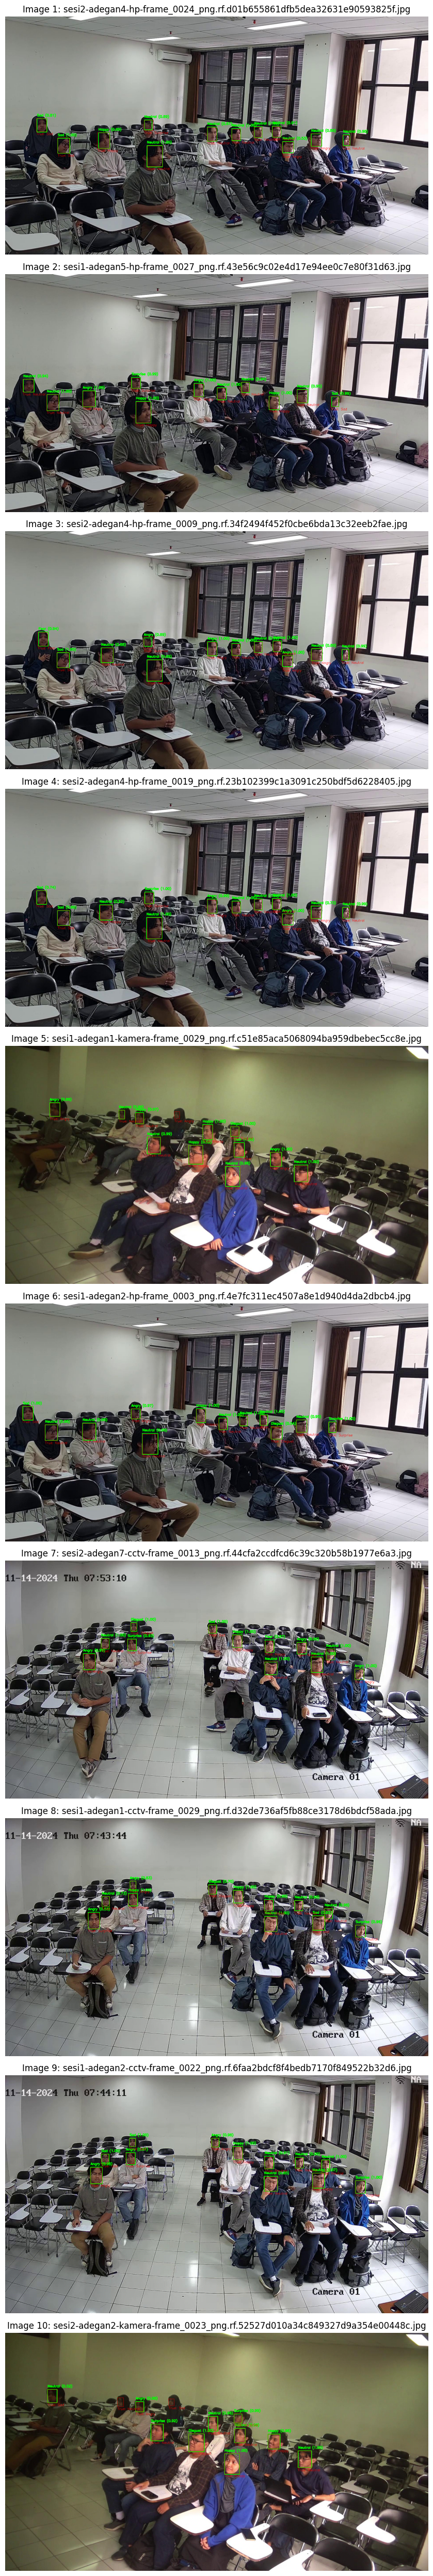

In [30]:
# Visualize results
print("\n=== Visualization ===")
visualize_results(dataset, yolo_model, fer_model, device, num_images=10)